In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 21
lead_time = 30
filename = '../../../data/Arctic_domain_mean_1979_2018 - Curated.csv'
pcmciplus_features = ['LW_down', 'snowfall', 'sst', 'sosaline', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
# df = df[7305:]
# df

# Reading the dataset
df = pd.read_csv(filename)
df = df[7305:]
df.head()

,Day,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
7305,1/1/1999,4.987515,0.891843,183.786092,1.120906,0.700735,0.501109,33.316996,273.467869,250.884060,985.112721,13823248
7306,1/2/1999,5.075952,0.905535,183.851814,1.193514,0.712730,0.482221,33.316996,273.453826,250.359328,984.092282,13885522
7307,1/3/1999,4.931520,0.911672,184.426913,1.263909,0.677339,0.480718,33.316996,273.454385,250.327500,982.300080,13884279
7308,1/4/1999,4.761644,0.911301,187.528326,1.269229,0.824016,0.697950,33.316996,273.459797,249.905730,983.250565,13912624
7309,1/5/1999,4.739850,0.901353,187.326709,1.552208,0.926681,0.835868,33.316996,273.463975,250.254873,984.247389,13890148


In [4]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[pcmciplus_features]
# df.tail(len(df))

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

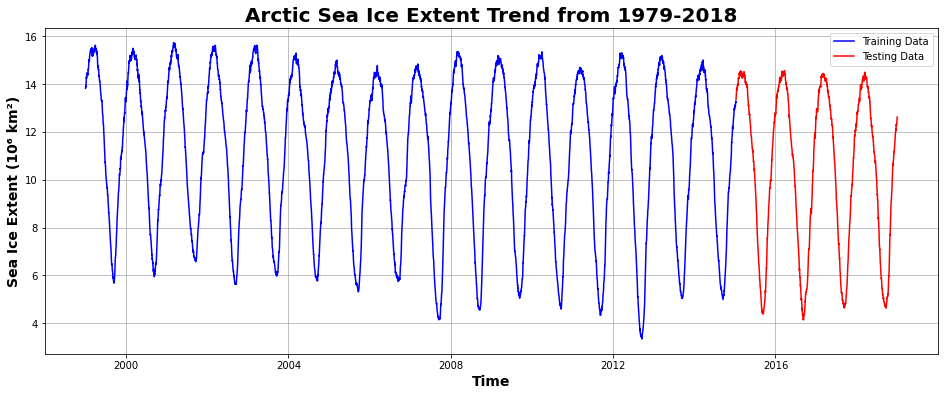

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            13824     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 120,961
Trainable params: 120,961
Non-trai

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0382 - mae: 0.1183 - mse: 0.0382

82/82 [==============================] - 11s 18ms/step - loss: 0.0359 - mae: 0.1139 - mse: 0.0359 - val_loss: 0.0024 - val_mae: 0.0422 - val_mse: 0.0024
Epoch 2/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0041 - mae: 0.0509 - mse: 0.0041

82/82 [==============================] - 1s 8ms/step - loss: 0.0040 - mae: 0.0505 - mse: 0.0040 - val_loss: 0.0021 - val_mae: 0.0345 - val_mse: 0.0021
Epoch 3/100
82/82 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0465 - mse: 0.0034

82/82 [==============================] - 1s 8ms/step - loss: 0.0034 - mae: 0.0465 - mse: 0.0034 - val_loss: 0.0016 - val_mae: 0.0341 - val_mse: 0.0016
Epoch 4/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0030 - mae: 0.0434 - mse: 0.0030

82/82 [==============================] - 1s 8ms/step - loss: 0.0030 - mae: 0.0433 - mse: 0.0030 - val_loss: 0.0013 - val_mae: 0.0291 - val_mse: 0.0013
Epoch 5/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0028 - mae: 0.0417 - mse: 0.0028

82/82 [==============================] - 1s 7ms/step - loss: 0.0028 - mae: 0.0416 - mse: 0.0028 - val_loss: 0.0012 - val_mae: 0.0284 - val_mse: 0.0012
Epoch 6/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0402 - mse: 0.0025

82/82 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0402 - mse: 0.0025 - val_loss: 0.0012 - val_mae: 0.0276 - val_mse: 0.0012
Epoch 7/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0382 - mse: 0.0023

82/82 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0383 - mse: 0.0023 - val_loss: 0.0015 - val_mae: 0.0318 - val_mse: 0.0015
Epoch 8/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0023 - mae: 0.0380 - mse: 0.0023

82/82 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0378 - mse: 0.0023 - val_loss: 0.0011 - val_mae: 0.0265 - val_mse: 0.0011
Epoch 9/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0363 - mse: 0.0021

82/82 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0364 - mse: 0.0021 - val_loss: 0.0010 - val_mae: 0.0262 - val_mse: 0.0010
Epoch 10/100
80/82 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0356 - mse: 0.0020

82/82 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0356 - mse: 0.0020 - val_loss: 9.1104e-04 - val_mae: 0.0241 - val_mse: 9.1104e-04
Epoch 11/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0341 - mse: 0.0018

82/82 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0340 - mse: 0.0018 - val_loss: 9.2812e-04 - val_mae: 0.0240 - val_mse: 9.2812e-04
Epoch 12/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0020 - mae: 0.0354 - mse: 0.0020

82/82 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0352 - mse: 0.0019 - val_loss: 0.0011 - val_mae: 0.0267 - val_mse: 0.0011
Epoch 13/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0341 - mse: 0.0018

82/82 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0341 - mse: 0.0018 - val_loss: 8.8547e-04 - val_mae: 0.0238 - val_mse: 8.8547e-04
Epoch 14/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0324 - mse: 0.0016

82/82 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0324 - mse: 0.0016 - val_loss: 0.0011 - val_mae: 0.0263 - val_mse: 0.0011
Epoch 15/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0323 - mse: 0.0017

82/82 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0323 - mse: 0.0017 - val_loss: 8.9263e-04 - val_mae: 0.0240 - val_mse: 8.9263e-04
Epoch 16/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0018 - mae: 0.0335 - mse: 0.0018

82/82 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0335 - mse: 0.0018 - val_loss: 0.0011 - val_mae: 0.0258 - val_mse: 0.0011
Epoch 17/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0317 - mse: 0.0016

82/82 [==============================] - 1s 7ms/step - loss: 0.0016 - mae: 0.0318 - mse: 0.0016 - val_loss: 8.5576e-04 - val_mae: 0.0234 - val_mse: 8.5576e-04
Epoch 18/100
81/82 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0309 - mse: 0.0015

82/82 [==============================] - 1s 7ms/step - loss: 0.0015 - mae: 0.0309 - mse: 0.0015 - val_loss: 0.0012 - val_mae: 0.0275 - val_mse: 0.0012
Epoch 19/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0015 - mae: 0.0309 - mse: 0.0015

82/82 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0308 - mse: 0.0015 - val_loss: 0.0011 - val_mae: 0.0253 - val_mse: 0.0011
Epoch 20/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0300 - mse: 0.0014

82/82 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0300 - mse: 0.0014 - val_loss: 0.0012 - val_mae: 0.0283 - val_mse: 0.0012
Epoch 21/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0302 - mse: 0.0015

82/82 [==============================] - 1s 7ms/step - loss: 0.0015 - mae: 0.0302 - mse: 0.0015 - val_loss: 0.0010 - val_mae: 0.0251 - val_mse: 0.0010
Epoch 22/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0302 - mse: 0.0015

82/82 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0300 - mse: 0.0014 - val_loss: 8.5416e-04 - val_mae: 0.0236 - val_mse: 8.5416e-04
Epoch 23/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0301 - mse: 0.0015

82/82 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0301 - mse: 0.0014 - val_loss: 9.7127e-04 - val_mae: 0.0248 - val_mse: 9.7127e-04
Epoch 24/100
82/82 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0292 - mse: 0.0014

82/82 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 0.0012 - val_mae: 0.0279 - val_mse: 0.0012
Epoch 25/100
80/82 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0291 - mse: 0.0014

82/82 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 8.0859e-04 - val_mae: 0.0227 - val_mse: 8.0859e-04
Epoch 26/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0291 - mse: 0.0013

82/82 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0291 - mse: 0.0013 - val_loss: 0.0014 - val_mae: 0.0297 - val_mse: 0.0014
Epoch 27/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0291 - mse: 0.0013

82/82 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0290 - mse: 0.0014 - val_loss: 7.5454e-04 - val_mae: 0.0216 - val_mse: 7.5454e-04
Epoch 28/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0292 - mse: 0.0014

82/82 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 7.7885e-04 - val_mae: 0.0223 - val_mse: 7.7885e-04
Epoch 29/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0283 - mse: 0.0013

82/82 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0282 - mse: 0.0013 - val_loss: 8.4394e-04 - val_mae: 0.0233 - val_mse: 8.4394e-04
Epoch 30/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0290 - mse: 0.0013

82/82 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0291 - mse: 0.0014 - val_loss: 0.0012 - val_mae: 0.0267 - val_mse: 0.0012
Epoch 31/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0292 - mse: 0.0013

82/82 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0292 - mse: 0.0013 - val_loss: 0.0011 - val_mae: 0.0266 - val_mse: 0.0011
Epoch 32/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0284 - mse: 0.0013

82/82 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0283 - mse: 0.0013 - val_loss: 7.7762e-04 - val_mae: 0.0222 - val_mse: 7.7762e-04
Epoch 33/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0281 - mse: 0.0013

82/82 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0282 - mse: 0.0013 - val_loss: 0.0016 - val_mae: 0.0334 - val_mse: 0.0016
Epoch 34/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0291 - mse: 0.0014

82/82 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0289 - mse: 0.0013 - val_loss: 8.6565e-04 - val_mae: 0.0233 - val_mse: 8.6565e-04
Epoch 35/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0279 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0279 - mse: 0.0013 - val_loss: 7.1514e-04 - val_mae: 0.0212 - val_mse: 7.1514e-04
Epoch 36/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0290 - mse: 0.0013

82/82 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0289 - mse: 0.0013 - val_loss: 8.4844e-04 - val_mae: 0.0234 - val_mse: 8.4844e-04
Epoch 37/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0273 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0273 - mse: 0.0012 - val_loss: 9.7783e-04 - val_mae: 0.0247 - val_mse: 9.7783e-04
Epoch 38/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012

82/82 [==============================] - 1s 7ms/step - loss: 0.0012 - mae: 0.0274 - mse: 0.0012 - val_loss: 0.0015 - val_mae: 0.0325 - val_mse: 0.0015
Epoch 39/100
80/82 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0281 - mse: 0.0013

82/82 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0281 - mse: 0.0013 - val_loss: 8.9357e-04 - val_mae: 0.0239 - val_mse: 8.9357e-04
Epoch 40/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0276 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0276 - mse: 0.0012 - val_loss: 8.1633e-04 - val_mae: 0.0222 - val_mse: 8.1633e-04
Epoch 41/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0274 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0274 - mse: 0.0012 - val_loss: 0.0012 - val_mae: 0.0294 - val_mse: 0.0012
Epoch 42/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0273 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0273 - mse: 0.0012 - val_loss: 8.2931e-04 - val_mae: 0.0230 - val_mse: 8.2931e-04
Epoch 43/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0267 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0267 - mse: 0.0011 - val_loss: 9.7109e-04 - val_mae: 0.0248 - val_mse: 9.7109e-04
Epoch 44/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0277 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0276 - mse: 0.0012 - val_loss: 7.5130e-04 - val_mae: 0.0224 - val_mse: 7.5130e-04
Epoch 45/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0273 - mse: 0.0012 - val_loss: 9.8962e-04 - val_mae: 0.0245 - val_mse: 9.8962e-04
Epoch 46/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0273 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0274 - mse: 0.0012 - val_loss: 0.0011 - val_mae: 0.0259 - val_mse: 0.0011
Epoch 47/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0274 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0274 - mse: 0.0012 - val_loss: 0.0010 - val_mae: 0.0247 - val_mse: 0.0010
Epoch 48/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0272 - mse: 0.0012 - val_loss: 7.0371e-04 - val_mae: 0.0208 - val_mse: 7.0371e-04
Epoch 49/100
82/82 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0272 - mse: 0.0012 - val_loss: 6.6217e-04 - val_mae: 0.0207 - val_mse: 6.6217e-04
Epoch 50/100
80/82 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0270 - mse: 0.0012 - val_loss: 8.9880e-04 - val_mae: 0.0242 - val_mse: 8.9880e-04
Epoch 51/100
81/82 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0265 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0265 - mse: 0.0011 - val_loss: 9.9616e-04 - val_mae: 0.0260 - val_mse: 9.9616e-04
Epoch 52/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0267 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0266 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0267 - val_mse: 0.0011
Epoch 53/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0262 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0263 - mse: 0.0011 - val_loss: 7.8137e-04 - val_mae: 0.0224 - val_mse: 7.8137e-04
Epoch 54/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0258 - mse: 0.0011

82/82 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0259 - mse: 0.0011 - val_loss: 7.5507e-04 - val_mae: 0.0220 - val_mse: 7.5507e-04
Epoch 55/100
75/82 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 8.6737e-04 - val_mae: 0.0233 - val_mse: 8.6737e-04
Epoch 56/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0270 - mse: 0.0012 - val_loss: 7.6159e-04 - val_mae: 0.0227 - val_mse: 7.6159e-04
Epoch 57/100
75/82 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0265 - val_mse: 0.0011
Epoch 58/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0262 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0262 - mse: 0.0011 - val_loss: 9.0996e-04 - val_mae: 0.0236 - val_mse: 9.0996e-04
Epoch 59/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0271 - mse: 0.0012

82/82 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0270 - mse: 0.0012 - val_loss: 7.5837e-04 - val_mae: 0.0219 - val_mse: 7.5837e-04
Epoch 60/100
80/82 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0259 - mse: 0.0011 - val_loss: 6.2482e-04 - val_mae: 0.0197 - val_mse: 6.2482e-04
Epoch 61/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 8.2312e-04 - val_mae: 0.0230 - val_mse: 8.2312e-04
Epoch 62/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0255 - mse: 0.0010

82/82 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0255 - mse: 0.0010 - val_loss: 9.3973e-04 - val_mae: 0.0252 - val_mse: 9.3973e-04
Epoch 63/100
82/82 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0251 - mse: 0.0010

82/82 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0251 - mse: 0.0010 - val_loss: 7.9529e-04 - val_mae: 0.0221 - val_mse: 7.9529e-04
Epoch 64/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0258 - mse: 0.0011

82/82 [==============================] - 1s 7ms/step - loss: 0.0011 - mae: 0.0259 - mse: 0.0011 - val_loss: 8.4268e-04 - val_mae: 0.0222 - val_mse: 8.4268e-04
Epoch 65/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0255 - mse: 0.0010

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 6.9709e-04 - val_mae: 0.0198 - val_mse: 6.9709e-04
Epoch 66/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0263 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0264 - mse: 0.0011 - val_loss: 6.2769e-04 - val_mae: 0.0200 - val_mse: 6.2769e-04
Epoch 67/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0256 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0255 - mse: 0.0011 - val_loss: 7.2872e-04 - val_mae: 0.0214 - val_mse: 7.2872e-04
Epoch 68/100
82/82 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0268 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0268 - mse: 0.0011 - val_loss: 5.6929e-04 - val_mae: 0.0183 - val_mse: 5.6929e-04
Epoch 69/100
75/82 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0253 - mse: 0.0010

82/82 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0251 - mse: 0.0010 - val_loss: 8.4424e-04 - val_mae: 0.0232 - val_mse: 8.4424e-04
Epoch 70/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0251 - mse: 0.0010        

82/82 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0253 - mse: 0.0010 - val_loss: 9.7034e-04 - val_mae: 0.0245 - val_mse: 9.7034e-04
Epoch 71/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0255 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0255 - mse: 0.0010 - val_loss: 7.2016e-04 - val_mae: 0.0210 - val_mse: 7.2016e-04
Epoch 72/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0262 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0261 - mse: 0.0011 - val_loss: 6.7776e-04 - val_mae: 0.0214 - val_mse: 6.7776e-04
Epoch 73/100
75/82 [==========================>...] - ETA: 0s - loss: 9.6167e-04 - mae: 0.0244 - mse: 9.6167e-04

82/82 [==============================] - 1s 8ms/step - loss: 9.6867e-04 - mae: 0.0245 - mse: 9.6867e-04 - val_loss: 9.4669e-04 - val_mae: 0.0242 - val_mse: 9.4669e-04
Epoch 74/100
75/82 [==========================>...] - ETA: 0s - loss: 9.9072e-04 - mae: 0.0248 - mse: 9.9072e-04

82/82 [==============================] - 1s 8ms/step - loss: 9.8462e-04 - mae: 0.0248 - mse: 9.8462e-04 - val_loss: 9.7329e-04 - val_mae: 0.0246 - val_mse: 9.7329e-04
Epoch 75/100
76/82 [==========================>...] - ETA: 0s - loss: 9.8335e-04 - mae: 0.0248 - mse: 9.8335e-04

82/82 [==============================] - 1s 8ms/step - loss: 9.8011e-04 - mae: 0.0248 - mse: 9.8011e-04 - val_loss: 7.0240e-04 - val_mae: 0.0221 - val_mse: 7.0240e-04
Epoch 76/100
80/82 [============================>.] - ETA: 0s - loss: 9.5140e-04 - mae: 0.0245 - mse: 9.5140e-04

82/82 [==============================] - 1s 13ms/step - loss: 9.5231e-04 - mae: 0.0245 - mse: 9.5231e-04 - val_loss: 7.5073e-04 - val_mae: 0.0216 - val_mse: 7.5073e-04
Epoch 77/100
77/82 [===========================>..] - ETA: 0s - loss: 9.5538e-04 - mae: 0.0244 - mse: 9.5538e-04

82/82 [==============================] - 1s 10ms/step - loss: 9.5452e-04 - mae: 0.0244 - mse: 9.5452e-04 - val_loss: 9.3856e-04 - val_mae: 0.0254 - val_mse: 9.3856e-04
Epoch 78/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0254 - mse: 0.0010

82/82 [==============================] - 1s 15ms/step - loss: 0.0010 - mae: 0.0253 - mse: 0.0010 - val_loss: 7.3288e-04 - val_mae: 0.0213 - val_mse: 7.3288e-04
Epoch 79/100
81/82 [============================>.] - ETA: 0s - loss: 9.4294e-04 - mae: 0.0243 - mse: 9.4294e-04

82/82 [==============================] - 1s 13ms/step - loss: 9.4313e-04 - mae: 0.0243 - mse: 9.4313e-04 - val_loss: 5.5863e-04 - val_mae: 0.0185 - val_mse: 5.5863e-04
Epoch 80/100
82/82 [==============================] - ETA: 0s - loss: 9.4385e-04 - mae: 0.0241 - mse: 9.4385e-04

82/82 [==============================] - 1s 9ms/step - loss: 9.4385e-04 - mae: 0.0241 - mse: 9.4385e-04 - val_loss: 7.8244e-04 - val_mae: 0.0232 - val_mse: 7.8244e-04
Epoch 81/100
75/82 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0263 - mse: 0.0011

82/82 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0262 - mse: 0.0011 - val_loss: 7.7556e-04 - val_mae: 0.0223 - val_mse: 7.7556e-04
Epoch 82/100
77/82 [===========================>..] - ETA: 0s - loss: 9.2763e-04 - mae: 0.0241 - mse: 9.2763e-04

82/82 [==============================] - 1s 8ms/step - loss: 9.2501e-04 - mae: 0.0240 - mse: 9.2501e-04 - val_loss: 6.2364e-04 - val_mae: 0.0194 - val_mse: 6.2364e-04
Epoch 83/100
78/82 [===========================>..] - ETA: 0s - loss: 9.2585e-04 - mae: 0.0241 - mse: 9.2585e-04

82/82 [==============================] - 1s 8ms/step - loss: 9.3207e-04 - mae: 0.0241 - mse: 9.3207e-04 - val_loss: 5.7598e-04 - val_mae: 0.0194 - val_mse: 5.7598e-04
Epoch 84/100
82/82 [==============================] - ETA: 0s - loss: 9.2859e-04 - mae: 0.0240 - mse: 9.2859e-04

82/82 [==============================] - 1s 8ms/step - loss: 9.2859e-04 - mae: 0.0240 - mse: 9.2859e-04 - val_loss: 6.7637e-04 - val_mae: 0.0209 - val_mse: 6.7637e-04
Epoch 85/100
78/82 [===========================>..] - ETA: 0s - loss: 9.4233e-04 - mae: 0.0242 - mse: 9.4233e-04

82/82 [==============================] - 1s 8ms/step - loss: 9.3863e-04 - mae: 0.0242 - mse: 9.3863e-04 - val_loss: 7.6158e-04 - val_mae: 0.0227 - val_mse: 7.6158e-04
Epoch 86/100
82/82 [==============================] - ETA: 0s - loss: 8.8296e-04 - mae: 0.0235 - mse: 8.8296e-04

82/82 [==============================] - 1s 8ms/step - loss: 8.8296e-04 - mae: 0.0235 - mse: 8.8296e-04 - val_loss: 6.8811e-04 - val_mae: 0.0207 - val_mse: 6.8811e-04
Epoch 87/100
75/82 [==========================>...] - ETA: 0s - loss: 8.5044e-04 - mae: 0.0229 - mse: 8.5044e-04

82/82 [==============================] - 1s 8ms/step - loss: 8.6672e-04 - mae: 0.0231 - mse: 8.6672e-04 - val_loss: 8.2403e-04 - val_mae: 0.0241 - val_mse: 8.2403e-04
Epoch 88/100
77/82 [===========================>..] - ETA: 0s - loss: 9.2148e-04 - mae: 0.0239 - mse: 9.2148e-04

82/82 [==============================] - 1s 8ms/step - loss: 9.3100e-04 - mae: 0.0240 - mse: 9.3100e-04 - val_loss: 7.1439e-04 - val_mae: 0.0206 - val_mse: 7.1439e-04
Epoch 89/100
80/82 [============================>.] - ETA: 0s - loss: 9.0330e-04 - mae: 0.0237 - mse: 9.0330e-04

82/82 [==============================] - 1s 8ms/step - loss: 9.0100e-04 - mae: 0.0237 - mse: 9.0100e-04 - val_loss: 7.4255e-04 - val_mae: 0.0213 - val_mse: 7.4255e-04
Epoch 90/100
76/82 [==========================>...] - ETA: 0s - loss: 8.3711e-04 - mae: 0.0226 - mse: 8.3711e-04

82/82 [==============================] - 1s 8ms/step - loss: 8.3426e-04 - mae: 0.0226 - mse: 8.3426e-04 - val_loss: 8.6813e-04 - val_mae: 0.0224 - val_mse: 8.6813e-04
Epoch 91/100
75/82 [==========================>...] - ETA: 0s - loss: 9.0704e-04 - mae: 0.0236 - mse: 9.0704e-04

82/82 [==============================] - 1s 8ms/step - loss: 8.9640e-04 - mae: 0.0235 - mse: 8.9640e-04 - val_loss: 6.6665e-04 - val_mae: 0.0210 - val_mse: 6.6665e-04
Epoch 92/100
76/82 [==========================>...] - ETA: 0s - loss: 8.4318e-04 - mae: 0.0227 - mse: 8.4318e-04

82/82 [==============================] - 1s 8ms/step - loss: 8.4113e-04 - mae: 0.0226 - mse: 8.4113e-04 - val_loss: 8.0213e-04 - val_mae: 0.0234 - val_mse: 8.0213e-04
Epoch 93/100
76/82 [==========================>...] - ETA: 0s - loss: 8.8414e-04 - mae: 0.0233 - mse: 8.8414e-04

82/82 [==============================] - 1s 8ms/step - loss: 8.8143e-04 - mae: 0.0232 - mse: 8.8143e-04 - val_loss: 7.8983e-04 - val_mae: 0.0214 - val_mse: 7.8983e-04
Epoch 94/100
79/82 [===========================>..] - ETA: 0s - loss: 9.1612e-04 - mae: 0.0238 - mse: 9.1612e-04

82/82 [==============================] - 1s 8ms/step - loss: 9.1666e-04 - mae: 0.0238 - mse: 9.1666e-04 - val_loss: 7.6878e-04 - val_mae: 0.0215 - val_mse: 7.6878e-04
Epoch 95/100
76/82 [==========================>...] - ETA: 0s - loss: 8.9462e-04 - mae: 0.0236 - mse: 8.9462e-04

82/82 [==============================] - 1s 8ms/step - loss: 8.8503e-04 - mae: 0.0235 - mse: 8.8503e-04 - val_loss: 7.3738e-04 - val_mae: 0.0221 - val_mse: 7.3738e-04
Epoch 96/100
75/82 [==========================>...] - ETA: 0s - loss: 8.3090e-04 - mae: 0.0227 - mse: 8.3090e-04

82/82 [==============================] - 1s 8ms/step - loss: 8.3389e-04 - mae: 0.0227 - mse: 8.3389e-04 - val_loss: 6.7193e-04 - val_mae: 0.0201 - val_mse: 6.7193e-04
Epoch 97/100
76/82 [==========================>...] - ETA: 0s - loss: 7.6612e-04 - mae: 0.0218 - mse: 7.6612e-04

82/82 [==============================] - 1s 8ms/step - loss: 7.7245e-04 - mae: 0.0219 - mse: 7.7245e-04 - val_loss: 7.0899e-04 - val_mae: 0.0205 - val_mse: 7.0899e-04
Epoch 98/100
77/82 [===========================>..] - ETA: 0s - loss: 7.7874e-04 - mae: 0.0219 - mse: 7.7874e-04

82/82 [==============================] - 1s 8ms/step - loss: 7.7736e-04 - mae: 0.0219 - mse: 7.7736e-04 - val_loss: 6.9011e-04 - val_mae: 0.0212 - val_mse: 6.9011e-04
Epoch 99/100
81/82 [============================>.] - ETA: 0s - loss: 8.1437e-04 - mae: 0.0224 - mse: 8.1437e-04

82/82 [==============================] - 1s 8ms/step - loss: 8.1382e-04 - mae: 0.0224 - mse: 8.1382e-04 - val_loss: 6.1759e-04 - val_mae: 0.0200 - val_mse: 6.1759e-04
Epoch 100/100
76/82 [==========================>...] - ETA: 0s - loss: 8.0252e-04 - mae: 0.0220 - mse: 8.0252e-04

82/82 [==============================] - 1s 8ms/step - loss: 8.0809e-04 - mae: 0.0221 - mse: 8.0809e-04 - val_loss: 5.8937e-04 - val_mae: 0.0191 - val_mse: 5.8937e-04


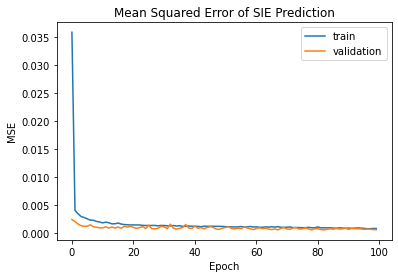

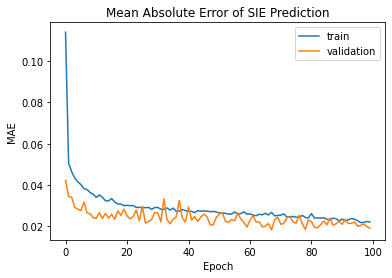

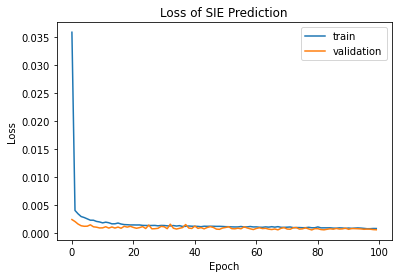

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

46/46 [==============================] - 1s 3ms/step


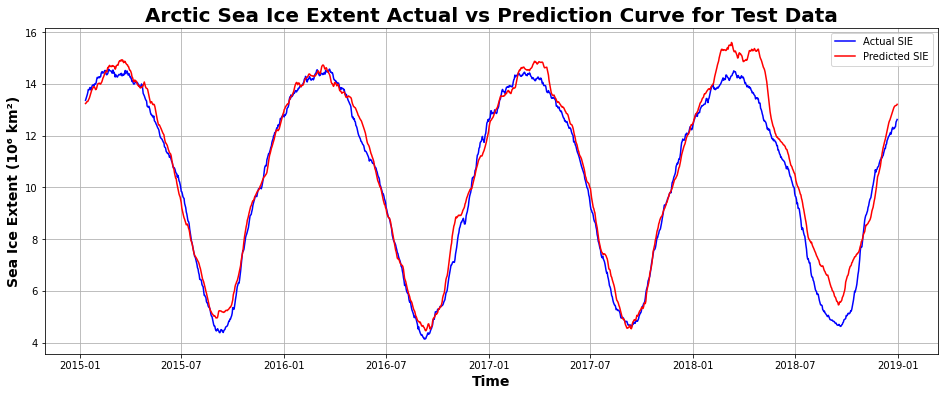

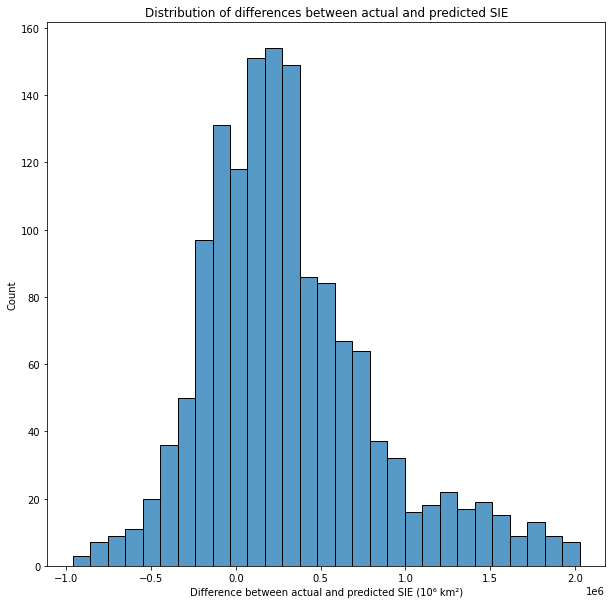

MSE :  361496127125.87683 (10⁶ km²)
MSPE : 0.6469156069917854 %
RMSE :  601245.4799213685 (10⁶ km²)
RMSPE : 8.043106408545055 %
MAE :  435374.02860096487 (10⁶ km²)
MAPE :  4.6250466247782045 %
R2 :  0.9676949500470741


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))

In [14]:
# while True:pass